In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

## Chapter 2 Exercise 11

This exercise analyzes the posterior of the location paramter $\theta$ of a Cuachy distribution $$p(y|\theta) \propto \frac 1 {(y-\theta)^2 + 1}.$$
The postiror is analyzed given the observation of the following `DATA` and assuming a uniform prior on the interval (0,100).

In [2]:
DATA = np.array([43,44,45,46.5,47.5])

### Part (a)

The function `smapledPosterior` calculates the unnormalized posterior for the specified number of points. The posterior is given by
$p(\theta|y_1 \dots y_n) \propto \prod_i p(y_i|\theta)p(\theta)$. Since the prior $p(\theta)$ is constant in the admissable interval from 0 to 100
this term is not needed inside the code. For numerical stability the logarithm of the posterior is calculated first and then exponentiated.
For such a small problem this is usually not necessary but it is generally good practice.

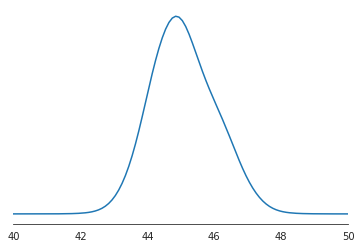

In [3]:
clogpdf = sts.distributions.cauchy.logpdf

def sampledPosetrior(num_samples=1000):
    sample_grid = np.linspace(0,100,num_samples)
    sample_postirior =  np.array([np.exp(np.sum(clogpdf(DATA,
                                                        loc = theta_sample,
                                                        scale=1)))
                        for theta_sample in sample_grid])
    return sample_grid,sample_postirior

plt.plot(*sampledPosetrior())
sns.despine(left=True)
plt.gca().yaxis.set_visible(False)
plt.xlim(40,50);

### Part (b)

Since we already have a function that samples the poterior pdf an easy way to draw random samples is to calculate an approximation to the inverse cdf,
draw samples from the uniform distribution on the interval (0,1) and then apply the inveerse cdf to obtain random samples for the posterior.

In [4]:
def posttiriorICDF(num_samples=1000):
    grid,sample_postirior = sampledPosetrior(num_samples)
    cdf = np.cumsum(sample_postirior)
    cdf = cdf/cdf[-1]
    return lambda x : np.interp(x,cdf,grid)

In [5]:
pICDF = posttiriorICDF()

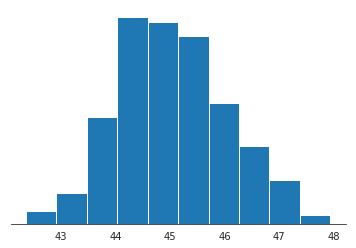

In [6]:
theta_samples = pICDF(np.random.uniform(size=1000))
plt.hist(theta_samples)
plt.gca().yaxis.set_visible(False)
sns.despine(left=True)

### Part (c)

Given the `theta_samples` that where obtained above it is straightforward to draw again samples from the Cauchy distribution for differen thetas to get
a distribution for $y_6$. When plotting samples of a Cauchy distribution it often helps to plot them on a log scale to cope with samples from the fat tails
that often distort histograms. Alternatively or additionally one can of course always restrict the x-range.

In [7]:
y6_samples = sts.distributions.cauchy.rvs(loc=theta_samples,scale=1)

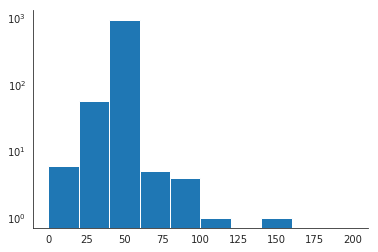

In [8]:
plt.hist(y6_samples,range=(0,200),log=True);
sns.despine()

### pymc3 illustration

The assignment was solved quite directly using basic funcitonality from *numpy* and *scipy*. In a realistic setting one would most likely try to use a probabalistic programmin library. In that spirit the following snippets illustrate the problem using pymc3. Although pymc3 cannot be used to answer all the assignment parts out of the bocks it should be apparent that the problem can described and analyzed in concise way.

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 1500/1500 [00:01<00:00, 957.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 10500/10500 [00:03<00:00, 2728.07it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
100%|██████████| 1000/1000 [00:00<00:00, 5726.94it/s]


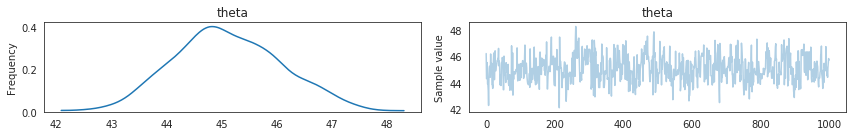

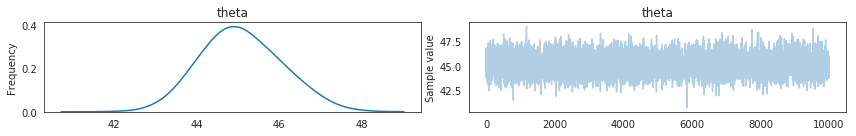

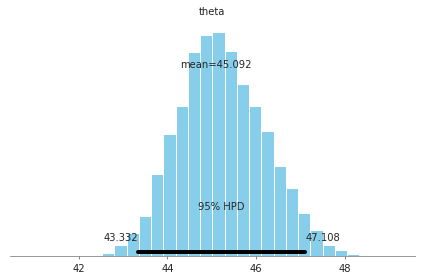

In [9]:
import pymc3 as pm

basic_model = pm.Model()

with basic_model:
    theta = pm.Uniform('theta',lower=0,upper=100)
    y = pm.Cauchy('y',alpha = theta,beta=1,observed = DATA)
    #calculate two trace for comaprison
    trace1 = pm.sample(1000,chains=1)
    trace2 = pm.sample(10000,chains=1)
    preds = pm.sample_posterior_predictive(trace2,samples=1000,size=1) #posterior prediction for (c)
    
pm.traceplot(trace1)
pm.traceplot(trace2) #essentially answer to (a)
pm.plot_posterior(trace2) #essentiall answer to (b)

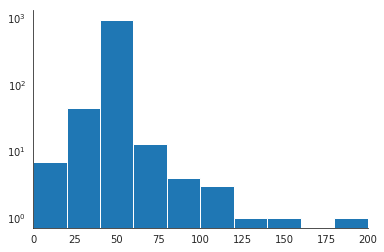

In [10]:
plt.hist(preds['y'].mean(axis=1),log=True,range=(0,200))
plt.xlim(0,200);
sns.despine()